## Logistic regression with MNIST

### Libraries

In [1]:
# libraries
using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, categorical
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

using GLM               # (lm works as regression; GLM not OK for categorical outcomes)
using MLJLinearModels   # LogisticClassifier

using LinearAlgebra     # pinv pseudo-inverse matrix
using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


### Functions

In [2]:
# functions for feature extraction
meanIntensity(img) = mean(Float64.(img))

function hSymmetry(img)
    imgFloat = Float64.(img)
    imgReverse = reverse(imgFloat, dims=1)
    return -mean( abs.(imgFloat - imgReverse) )
end

hSymmetry (generic function with 1 method)

In [3]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

vector2Image(vec, h, v) = reshape(Float64.(vec), (h, v))

function rescaleByColumns(X)
    # using StatsBase
    X = Float64.(X)
    dt = StatsBase.fit(ZScoreTransform, X; dims=1, center=true, scale=true)
    rescaledX = StatsBase.transform(dt, X)
end


rescaleByColumns (generic function with 1 method)

### MNIST data

,,,,

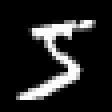
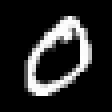
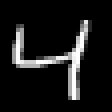
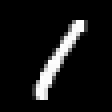
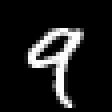

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

### Logistic classification (two classes - two predictors)

In [6]:
# convert images to vectors
trainX = batchImage2Vector(trainX)
size(trainX)

(42001,)

In [7]:
# select classes for prediction
c = (1, 5)

# data selection from above classes and sizes
trainX = vcat( trainX[trainY .== c[1] ], trainX[ trainY .== c[2] ] )
trainY = vcat( trainY[trainY .== c[1] ], trainY[ trainY .== c[2] ] )
display(levels(trainY))
size(trainX), size(trainY)

2-element Vector{Int64}:
 1
 5

((8514,), (8514,))

In [8]:
# generate predictors
N = size(trainX)[1]

a = [meanIntensity(trainX[i]) for i in 1:N]
b = [hSymmetry(trainX[i])     for i in 1:N]
trainXLog = hcat(a, b)
trainXLog = rescaleByColumns(trainXLog)
display(size(trainXLog))

# generate outcome
trainYLog = copy(trainY);


(8514, 2)

In [9]:
# specific conversions for MLJ
trainXLog = DataFrame(trainXLog, :auto)
trainYLog = categorical(trainYLog, ordered=true);

In [10]:
# fit the model
mdl = LogisticClassifier()
mach = machine(mdl, trainXLog, trainYLog)
fit!(mach)

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464


Machine{LogisticClassifier,…} trained 1 time; caches data
  model: LogisticClassifier
  args: 
    1:	Source @410 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @847 ⏎ `AbstractVector{OrderedFactor{2}}`


In [11]:
# predict with trainset
params = fitted_params(mach)
p = MLJ.predict(mach, trainXLog)
p[1:5]

5-element CategoricalDistributions.UnivariateFiniteArray{OrderedFactor{2}, Int64, UInt32, Float64, 1}:
 UnivariateFinite{OrderedFactor{2}}(1=>0.633, 5=>0.367)
 UnivariateFinite{OrderedFactor{2}}(1=>0.704, 5=>0.296)
 UnivariateFinite{OrderedFactor{2}}(1=>0.698, 5=>0.302)
 UnivariateFinite{OrderedFactor{2}}(1=>0.632, 5=>0.368)
 UnivariateFinite{OrderedFactor{2}}(1=>0.647, 5=>0.353)

In [12]:
p[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■■■■■■■■■■■■■■■■■■ 0.6330328095306961   
   5 ┤■■■■■■■■■■■■ 0.36696719046930387          
     └                                        ┘ 

In [25]:
# convert probability to classes
ŷ = predict_mode(mach)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1
 1
 1
 1
 1

In [15]:
# metrics
confmat(ŷ, trainYLog)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4651     │    1281     │
├─────────────┼─────────────┼─────────────┤
│      5      │     68      │    2514     │
└─────────────┴─────────────┴─────────────┘


,,,,,,,

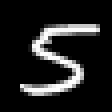
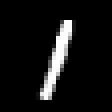
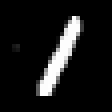
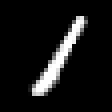
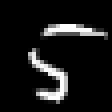
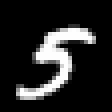
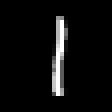
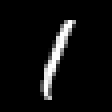

8-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 5
 1
 1
 1
 5
 5
 1
 1

8-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 5
 1
 1
 1
 1
 5
 1
 1

In [27]:
# demonstration of prediction accuracy
v = rand(1:N, 8)

display([MNIST.convert2image(vector2Image( trainX[i], 28, 28) ) for i in v])
display(trainYLog[v])
display(ŷ[v])